## QPPQ Ensemble Generation

Here we consider an ensemble of generated the historic reconstruction timeseries using a probabalistic variation of the QPPQ method.  

In [6]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sys
import datetime as dt
import seaborn as sns

# Import the QPPQ model
from QPPQModel import StreamflowGenerator

from data_processing import export_dict_ensemble_to_hdf5

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches


In [2]:
# Model generation specifications
full_date_range = ('1945-01-01', '2023-06-01')
N_ENSEMBLE = 50
N_REALIZATIONS = 50
K = 5
donor_fdc = 'nhmv10'
hru_scaled = False
remove_mainstem_gauges = True
regression_nhm_inflow_scaling = True

# Constants
cms_to_mgd = 22.82
fdc_quantiles = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]

### Load data 
Q = pd.read_csv(f'./data/historic_unmanaged_streamflow_1900_2023_cms.csv', sep = ',', index_col = 0, parse_dates=True)*cms_to_mgd
nhm_flow = pd.read_csv(f'{pywrdrb_directory}/input_data/gage_flow_nhmv10.csv', sep =',',  index_col = 0, parse_dates=True)
nwm_flow = pd.read_csv(f'{pywrdrb_directory}/input_data/gage_flow_nwmv21.csv', sep =',',  index_col = 0, parse_dates=True)
nyc_nhm_inflows = pd.read_csv('./data/nyc_inflow_nhm_streamflow.csv', sep = ',', parse_dates=True)


prediction_locations = pd.read_csv(f'./data/prediction_locations.csv', sep = ',', index_col=0)
gauge_meta = pd.read_csv(f'./data/drb_unmanaged_usgs_metadata.csv', sep = ',', dtype = {'site_no':str})
gauge_meta.set_index('site_no', inplace=True)

# Some gauge data is faulty
gauge_meta.loc['01414000', 'begin_date'] = '1996-12-05'
gauge_meta.loc['0142400103', 'begin_date'] = '1996-12-05'

# Get estiamtes of FDCs at all nodes; to be used for QPPQ when no data is available
node_fdcs = pd.DataFrame(index = prediction_locations.index, columns=fdc_quantiles)
if donor_fdc == 'nhmv10':
    fdc_donor_flow = nhm_flow
elif donor_fdc == 'nwmv21':
    fdc_donor_flow = nwm_flow
else:
    print('Invalid donor_fdc specification. Options: nhmv10, nwmv21')

for i, node in enumerate(prediction_locations.index):
    node_fdcs.loc[node, :] = np.quantile(fdc_donor_flow.loc[:,node], fdc_quantiles)
    
# Remove outflow gauges from flow data
for node, sites in obs_pub_site_matches.items():
    if f'USGS-{node}' in Q.columns:
        print(f'Removing {node} from data.')
        Q = Q.drop(f'USGS-{node}', axis=1)

# Remove Trenton mainstem gauge
if remove_mainstem_gauges:
    if f'USGS-{obs_pub_site_matches["delTrenton"]}' in Q.columns:
        print(f'Removing Trenton gauge from data.')
        Q = Q.drop(f'USGS-{obs_pub_site_matches["delTrenton"]}', axis=1)
    if f'USGS-{obs_pub_site_matches["delMontague"]}' in Q.columns:
        print(f'Removing Montague gauge from data.')
        Q = Q.drop(f'USGS-{obs_pub_site_matches["delMontague"]}', axis=1)

    obs_pub_site_matches['delTrenton'] = None
    obs_pub_site_matches['delDRCanal'] = None
    obs_pub_site_matches['delMontague'] = None

# Make sure other inflow gauges are in the dataset
missing = 0
for node, sites in obs_pub_site_matches.items():
    if sites is not None:
        for s in sites:
            if f'USGS-{s}' not in Q.columns:
                print(f'Site {s} for node {node} is not available')
#assert(missing == 0), 'Atleast one of the inflow gauge timeseries if not available in the data.'


In [3]:
# Set-up QPPQ
reconstructed_sites = []
for node, sites in obs_pub_site_matches.items():
    if node == 'delDRCanal':
        pass
    elif sites is None:
        reconstructed_sites.append(node)
    else:
        for s in sites:
            reconstructed_sites.append(s)

# Intialize storage
max_daterange = pd.date_range('1945-01-01', '2023-06-01')
max_annual_NA_fill = 20
Q_reconstructed = pd.DataFrame(index=max_daterange, columns = reconstructed_sites)
ensemble_Q_reconstructed = {}

N_YEARS = int(np.floor(len(max_daterange)/365))

starts = [f'{1945+i}-01-01' for i in range(N_YEARS)]
ends = [f'{1945+i}-12-31' for i in range(N_YEARS)]
daterange_subsets = np.vstack([starts, ends]).transpose()
assert(pd.to_datetime(daterange_subsets[-1,-1]).date() <= Q.index.max().date()), 'The historic data must be more recent than QPPQ daterange.'

In [4]:
## QPPQ prediction
# Generate 1 year at a time, to maximize the amount of data available for each years QPPQ
for real in range(N_REALIZATIONS):
    print(f'Generation realization {real} of {N_REALIZATIONS}.')
    for i, dates in enumerate(daterange_subsets):
        # Run predictions one location at a time
        for node, sites in obs_pub_site_matches.items():
            
            # Pull gauges that have flow during daterange
            Q_subset = Q.loc[dates[0]:dates[1], :].dropna(axis=1)
            subset_sites = [f'{i.split("-")[1]}' for i in Q_subset.columns]
            gauge_meta_subset = gauge_meta.loc[subset_sites, :]
            gauge_meta_subset.index = Q_subset.columns
            
            # Initialize the model
            model = StreamflowGenerator(K= K,
                                        observed_flow = Q_subset, 
                                        observation_locations=gauge_meta_subset,
                                        probabalistic_sample = True)

            # Handle sites with historic data
            if sites is not None:
                for s in sites:
                    # First, use observation data if available
                    number_of_nas = Q.loc[dates[0]:dates[1], f'USGS-{s}'].isna().sum()
                    if (number_of_nas == 0):
                        Q_reconstructed.loc[dates[0]:dates[1], s] = Q.loc[dates[0]:dates[1], f'USGS-{s}'].values
                    elif (number_of_nas <= max_annual_NA_fill):
                        # print(f'Filling {number_of_nas} NAs for site {s} using median.')
                        Q_reconstructed.loc[dates[0]:dates[1], s] = Q.loc[dates[0]:dates[1], f'USGS-{s}'].values
                        
                        # Fill NA using median                    
                        na_indices = Q.loc[dates[0]:dates[1],:].loc[Q.loc[dates[0]:dates[1], f'USGS-{s}'].isna(), :].index
                        median_flow = np.median(Q.loc[dates[0]:dates[1], :].loc[~Q.loc[dates[0]:dates[1], f'USGS-{s}'].isna(), f'USGS-{s}'])
                        Q_reconstructed.loc[na_indices.date, s] = median_flow
                            
                    # If flow data isn't available, use historic observation to generate FDC and make PUB predictions
                    else:
                        # print(f'Using partial record for {s} during {dates}')
                        location = gauge_meta.loc[s, ['long', 'lat']].values
                        incomplete_site_flows = Q.loc[:, f'USGS-{s}'].dropna(axis=0)
                        
                        # Only use site flows for FDC if longer than 10-year record
                        if len(incomplete_site_flows)/365 >= 10:
                            fdc = np.quantile(incomplete_site_flows.values, fdc_quantiles)
                        else:
                            fdc = node_fdcs.loc[node, :].astype('float').values            
            
                        Q_reconstructed.loc[dates[0]:dates[1], s] = model.predict_streamflow(location, fdc).values.flatten()
            else:
                # print(f'Full PUB for {s} during {dates}')
                location = prediction_locations.loc[node, ['long', 'lat']].values
                fdc = node_fdcs.loc[node, :].astype('float').values

                Q_reconstructed.loc[dates[0]:dates[1], node] = model.predict_streamflow(location, fdc).values.flatten()
    
    ensemble_Q_reconstructed[f'realization_{real}'] = Q_reconstructed.copy()
# assert(Q_reconstructed.isna().sum().sum() == 0), 'There are NA values in the reconstruction.'


Generation realization 0 of 5.


Generation realization 1 of 5.
Generation realization 2 of 5.
Generation realization 3 of 5.
Generation realization 4 of 5.


In [24]:
def export_dict_ensemble_to_hdf5(dict, output_file):
    N = len(dict)

    T, M = dict[f'realization_0'].shape
    column_labels = dict[f'realization_0'].columns.to_list()
    
    with h5py.File(output_file, 'w') as f:
        for i in range(N):
            data = dict[f'realization_{i}']
            grp = f.create_group(f"realization_{i+1}")
                    
            # Store column labels as an attribute
            grp.attrs['column_labels'] = column_labels
            
            # Create datasets for each location's timeseries
            for j in range(M):
                dataset = grp.create_dataset(column_labels[j], data=list(data.iloc[:,j].values))


export_dict_ensemble_to_hdf5(ensemble_Q_reconstructed, f'./outputs/ensembles/historic_reconstruction_daily_ensemble_{N_REALIZATIONS}.hdf5')


## Visualize ensemble

A quick check on the range of flows observed.

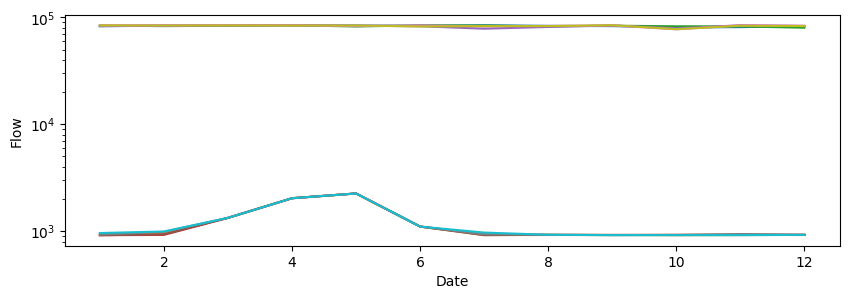

In [25]:
node = 'delTrenton'
inflow_gauges = obs_pub_site_matches[node]
start_date = '2001-11-01'
end_date = '2002-01-01'

fig, ax = plt.subplots(figsize = (10,3))

for real in range(N_REALIZATIONS):
    if inflow_gauges:
        Q = ensemble_Q_reconstructed[f'realization_{real}'].loc[:,inflow_gauges].sum(axis=1)
    else:
        Q = ensemble_Q_reconstructed[f'realization_{real}'].loc[:,node]
    month_mins = Q.groupby(Q.index.month).min()
    month_max = Q.groupby(Q.index.month).max()
    ax.plot(month_max.index, month_max, label = f'R{real}')
    ax.plot(month_mins.index, month_mins, label = f'R{real}')
    # ax.plot(Q.index, Q, alpha = 0.4)


plt.yscale('log')
plt.ylabel('Flow')
# plt.legend()
plt.xlabel('Date')
plt.show()    
